# Textual Analysis of XPN's AtoZ Playlist

One of the cool things about [WXPN](http://xpn.org)
is their frequent special programming which is always interesting.
This year, they put together a multi-day alphabetical playlist
called [XPN's A to Z](http://xpn.org/music-artist/xpn-a-z).
As has been the case for a lot of these events,
the [#XPNAtoZ](https://twitter.com/search?q=%23XPNAtoZ) tweet stream
is as interesting as the music.
Initially I was confused by why
Johnny Cash's _A Boy Named Sue_ was the 3rd song,
when I'd have filed it in the Bs.
So, after getting involved in a 
[twitter exchange](https://twitter.com/brianjgainor/status/803966913483329536)
on the topic of treating articles as significant,
an idea came to me.
I could look at the data to see how words that typically live on stop lists
skewed the distribution of the music.
Along the way other interesting explorations might turn up.
What follows is the result.

## Status

- At this point, we're officially into week 3
  and still in the Ts.
  But there are still surprises ahead.
- So far the obvious aggregations have been done.
  But there still may be interesting oppurtunities to find patterns. 
- Graphs have gotten a lot less ugly
  since moving to [Seaborn](http://seaborn.pydata.org/) for plotting
  and spending a bit of time tidying things up.
- I've figured out my issues with [MusicBrainz](https://musicbrainz.org/)
  integration, so counts by year are back.  And not clearly wrong
  this time.

## Load the data

The [AtoZ Playlist page](http://xpn.org/music-artist/xpn-a-z)
contains a directory of songs by first letter.
Behind the scenes, it makes ReST request to their backend.
Origionally I said I ought to cache the data.
Mostly I was concerned about it going away.
But as I integrate data from 
[MusicBrainz](https://musicbrainz.org/),
which rate limites requests, caching becomes important,
though it adds complexity.
Data can be precached by running `load_xpn_cache.py`

In [1]:
%matplotlib inline
from IPython.display import display, HTML
from lxml import html
import requests
import pandas as pd
import os.path as path
import csv

cache_dir = './cache'
xpn_cache = path.join(cache_dir, 'xpn')

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
letters_so_far = list(alphabet)[:20]

playlist = pd.DataFrame(None, columns = ('Title', 'Artist'))
for letter in letters_so_far:
    cache_file = path.join(xpn_cache, '%s.csv' % letter)
    if path.exists(cache_file):
        df = pd.read_csv(cache_file)
    else:
        rows = []
        page = requests.get('http://xpn.org/static/az.php?q=%s' %  letter)
        tree = html.fromstring(page.content)
        songs = tree.xpath('//li/text()')
        for song in songs:
            rows.append(play.split(' - ', 1))
        df = pd.DataFrame(rows, columns = ('Title', 'Artist'))
        df.to_csv(cache_file, index=False)
    playlist = playlist.append(df, ignore_index=True)


### Data Cleanup and Enrichment

First of all there are some duplicates in the data set.
We'll clean those up before doing anything else.

In [2]:
HTML(playlist.loc[playlist.duplicated()].to_html())

,Title,Artist
731,Clocks,Coldplay
2701,Lively Up Yourself,Bob Marley & The Wailers
4740,The Rockafeller Skank,Fatboy Slim
4778,The Way I Am,Ingrid Michaelson
4840,This Is Hip,John Lee Hooker


So we delete those.  
We also add a few artificial columns to make reporting easier.
First Letter and First Word are, well the first letter and word of the title.

For what it's worth, "first word" turns out to be a harder problem that it might seem.
For way more detail than a normal human would want,
see the [Word Splitting](Word Splitting.ipynb) notebook.
Short version, any sequence of letters or apostrophes is a word
for our purposes.

We can also do sentiment analysis on the titles.
Song titles are not exactly idiomatic English,
ideally we would build a training model manually.
But for expediency we can try 
[TextBlob](https://textblob.readthedocs.io/en/dev/)
a convenience library that sits on top of
[NLTK](http://www.nltk.org/), and comes with a pre-trained model.

Finally we can search [MusicBrainz](https://musicbrainz.org/)
for likely recordings matching the artist and title
and use that to make a good guess 
at the year the song was first published.
Because the MusicBrainz interface is rate limited,
this can be slow.
Running the whole play list is over an hour.
So we're only use pre-cached data here.
To see how it gets there see `load_mb_cache.py`.

In [3]:
# Drop dups
playlist = playlist.drop_duplicates()

# First is the first letter of the title
playlist = playlist.join(playlist.apply(lambda x: x[0][0].upper(), axis=1).to_frame('First Letter'))

from nltk.tokenize import RegexpTokenizer
custom_tokenize = RegexpTokenizer("[\w'\-]+|[^\w'\s\-]").tokenize

# First Word, extract the 'first word' of the title
playlist = playlist.join(playlist.apply(lambda x: custom_tokenize(x[0])[0], axis=1).to_frame('First Word'))

# Sentiment Analysis
# Polarity runs -1.0 (negative) ... +1.0 (postive) sentiment
# Subjectivity runs 0.0 .. 1.0
# Note apply needs to run on a 2xN matrix to treat the result
# as a dataframe, otherwise there's no point in selecting the 
# Artist column
from textblob import TextBlob
sentiment = playlist[['Title', 'Artist']].apply(lambda x: list(TextBlob(x[0]).sentiment),
                           axis=1)
sentiment.columns = ['Polarity', 'Subjectivity']
playlist = playlist.join(sentiment)

# Add Album data from MusicBrainz
# This api is rate limited to about 1 request/sec
# running the whole list will take well over an hour
# we rely completely on pre-loading the cache here
# see load_mb_cache.py for how stuff gets there
mb_cache = path.join(cache_dir, 'musicbrainz', 'song_years.csv')
if path.exists(mb_cache):
    years = pd.read_csv(mb_cache)
else:
    years = pd.DataFrame(None, columns=('Title','Artist', 'Year'))

# Join that up to a copy of the play list
playlist = playlist.merge(years, how='left')
playlist['Year'] = playlist['Year'].fillna(0.0).astype(int)


So the resulting dataframe has seven fields:
Title, Artist, First Letter, First Word,
Sentiment Polarity and Subjectivity,
and finally Year of publication.
Before diving in, just to get perspective,
here are some basic stats on the data and a dump of the first and last few rows.

In [4]:
HTML(playlist.describe(include='all', percentiles=[]).to_html(na_rep=''))

,Title,Artist,First Letter,First Word,Polarity,Subjectivity,Year
count,5027,5027,5027,5027,5027.000000,5027.000000,5027.000000
unique,4674,1554,20,1945,,,
top,Hold On,The Beatles,T,The,,,
freq,5,121,608,254,,,
mean,,,,,0.038236,0.158930,1919.165307
std,,,,,0.207889,0.281986,353.238968
min,,,,,-1.000000,0.000000,0.000000
50%,,,,,0.000000,0.000000,1980.000000
max,,,,,1.000000,1.000000,2017.000000


In [5]:
HTML(playlist.head(5).to_html())

,Title,Artist,First Letter,First Word,Polarity,Subjectivity,Year
0,ABC,Jackson 5,A,ABC,0.000000,0.000000,1983
1,A Big Hunk O' Love,Elvis Presley,A,A,0.250000,0.350000,1959
2,A Boy Named Sue (live),Johnny Cash,A,A,0.136364,0.500000,1969
3,A Case Of You,Joni Mitchell,A,A,0.000000,0.000000,1971
4,A Certain Girl,Ernie K-Doe,A,A,0.214286,0.571429,1988


In [6]:
HTML(playlist.tail(5).to_html())

,Title,Artist,First Letter,First Word,Polarity,Subjectivity,Year
5022,Turn Your Lights Down Low,Bob Marley & The Wailers,T,Turn,-0.077778,0.294444,1977
5023,Turn Your Radio On,John Hartford,T,Turn,0.000000,0.000000,1971
5024,Turning Japanese,The Vapors,T,Turning,0.000000,0.000000,1980
5025,Tusk,Fleetwood Mac,T,Tusk,0.000000,0.000000,1979
5026,Tutti Frutti,Little Richard,T,Tutti,0.000000,0.000000,1967


## Data Analysis

### Songs by Letter

It's the simplest thing one can look at.
And I wouldn't think it all that interesting.
But given how uneven the distribution has been,
I thought it might be intestesting.
And there have been a few "how long with th I's go"
side conversations.

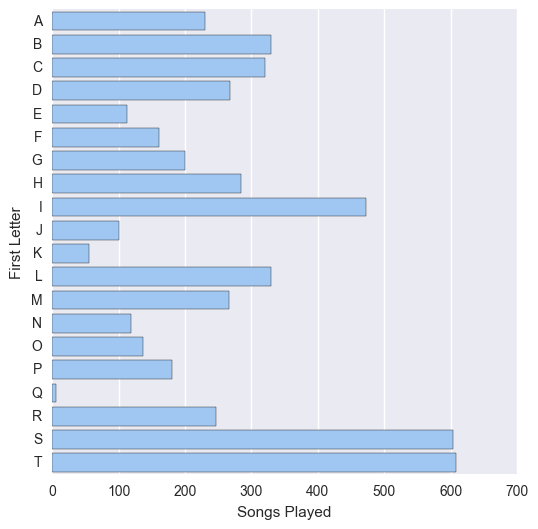

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.countplot(y='First Letter', data=playlist, color='b')
ax.set(xlabel="Songs Played")

### Most Frequent Artists

Even this early in the playlist,
some artists show up often.
This might say something about the music the station plays,
or the listeners as much of this list comes from previous 
playlists like "885 best songs of all time"
or my favorite, the "85 worst songs of all time."
For the moment, let's just look at the most frequent dozen or so.

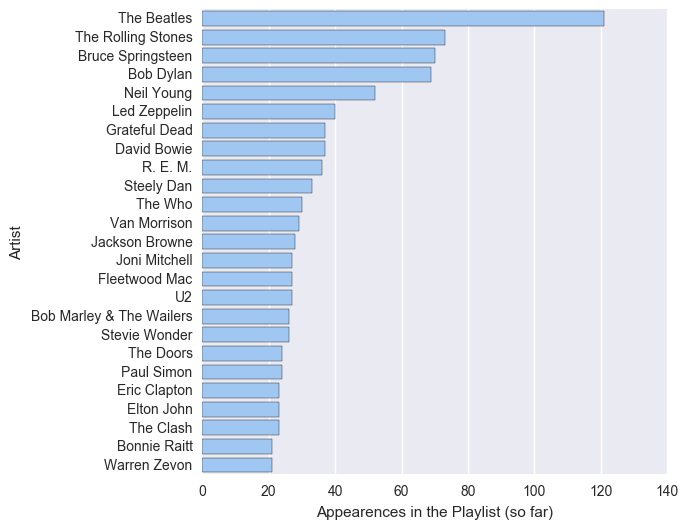

In [8]:
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'count'))
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='count', data=artists.head(25), color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

### Duplicate Titles
From the titles alone, covers and songs that just happen to have the same title
look the same.
But even early on, the number of duplicate titles
was more than I'd have expected.
And a few are more than just duplicated.
In fact, it's crazy that there were four songs called "Crazy",
that that's in a 9 way tie for 3rd place,
and "Home" and "Hold on" have 5 instances each.

What I can't tell is if this all says that there are a fair number of covers in the list,
or if artists just are not that creative at picking names.

#### Frequency Distribution of Titles

Since there are a lot of duplicate titles,
it might be easier to start by looking at the overall distribution.
That is, how many titles  show up 2, 3, or more times.

[<matplotlib.text.Text at 0x1134b6ed0>, <matplotlib.text.Text at 0x1134d4950>]

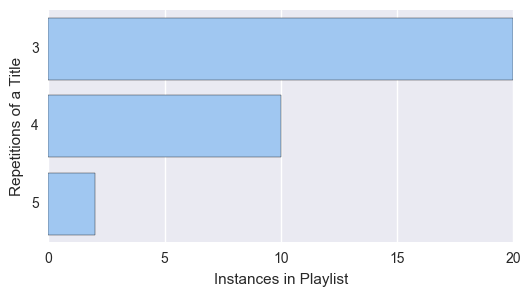

In [9]:
# Build a Datafrae of Unique Titles to Appearence counts
c = playlist['Title'].value_counts()
title_counts = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                           columns=('Title', 'Count'))
f, ax = plt.subplots(figsize=(6, 3))
sns.set_color_codes('pastel')
sns.countplot(y='Count', data=title_counts[title_counts['Count'] >2],
              color='b')
ax.set(ylabel="Repetitions of a Title", xlabel="Instances in Playlist")

#### Most Popular Titles
Of course we want to know what those titles were.
At least the really popular ones.

In [10]:
HTML(title_counts[title_counts['Count'] > 3].to_html())

,Title,Count
0,Hold On,5
1,Home,5
2,Fire,4
3,Fever,4
4,Hard to Handle,4
5,It's Alright,4
6,Dreams,4
7,Night Train,4
8,Crazy,4
9,Human,4


### Most Frequent First Words

This is the question that started me down this path.
How much do common "stop words" like articles or propositions 
skew the distribution?
Or do so many songs start with a small set of words
that no amount of pruning would even the distribution out?
Here's an early look a the top 25 first words.
Yes, "A" *was* up there.
But even early on it wasn't in the lead.
Perhaps my initial concerns were unfounded.
Except that the long reign of "I" as the top first word has ended
as, after almost 18 hours of air time, "The" has overtaken it,
and is still going.

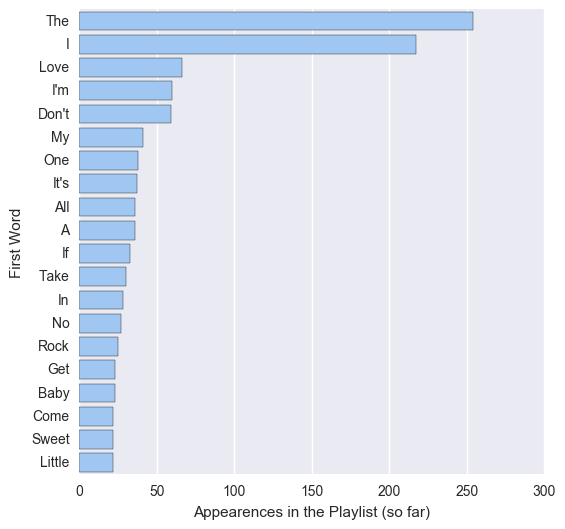

In [11]:
c = playlist['First Word'].value_counts()
words = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('First Word', 'count'))

f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='First Word', x='count', data=words.head(20), color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

The same data as a word cloud,
though the python `wordcloud` package does a few things work against us
and are not customizable in the released version.

<function matplotlib.pyplot.show>

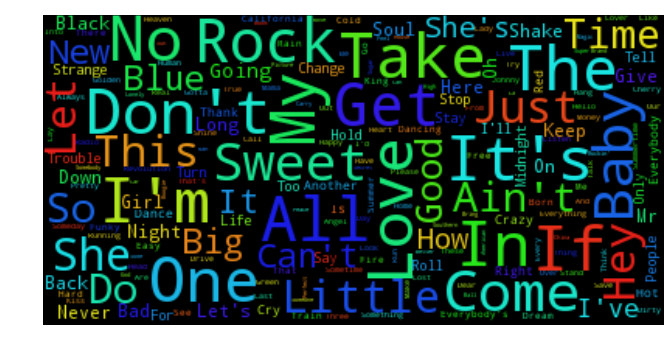

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

firsts = playlist.apply(lambda x: custom_tokenize(x[0])[0], axis=1)
wordcloud = WordCloud(max_font_size=40, stopwords='').generate(' '.join(firsts.tolist()))
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show


### Sentiment Analysis
Sentiment Analysis rates text on how positive or negative is.
How happy are the songs XPN plays?
How many are angry (or more likely sad)?
The vast majority of the titles are neutral.

[<matplotlib.text.Text at 0x1141bca50>, <matplotlib.text.Text at 0x1141b71d0>]

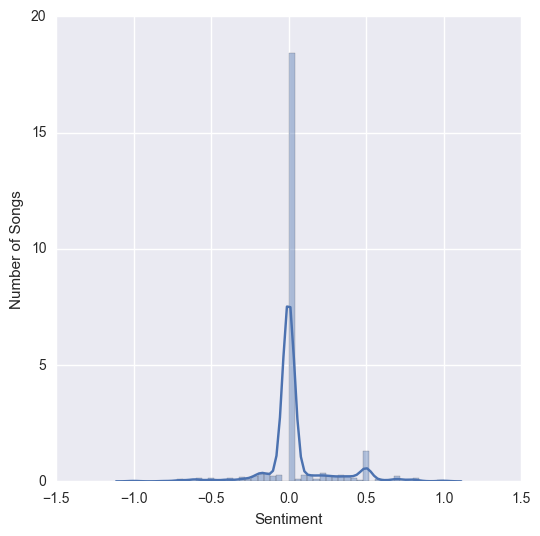

In [13]:
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(playlist['Polarity'])
ax.set(xlabel="Sentiment", ylabel="Number of Songs")

But it's easier to see the distribution
if we ignore the neutral songs.
Here we see there's a decent spread,
with a reasonably strong skew towards the positive.
Perhaps songwriters often mine pain for themes,
but we prefer to play happy songs.

[<matplotlib.text.Text at 0x113ed0210>, <matplotlib.text.Text at 0x11475af10>]

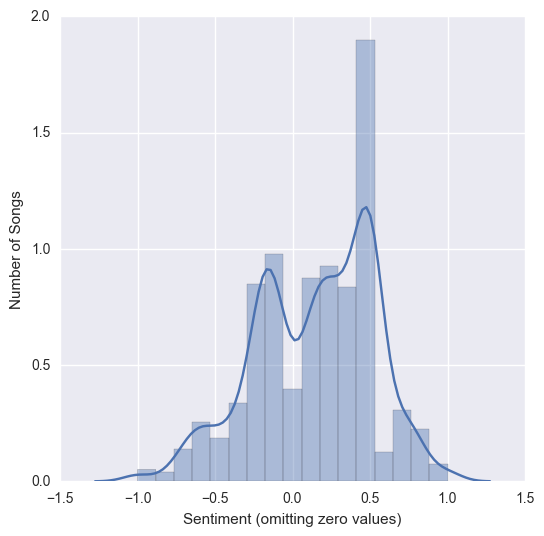

In [14]:
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(playlist[playlist['Polarity'] != 0]['Polarity'])
ax.set(xlabel="Sentiment (omitting zero values)", ylabel="Number of Songs")

What are some of the most positive songs?

In [15]:
HTML(playlist.sort_values('Polarity', ascending=False)[['Artist', 'Title', 'Polarity']].head(10).to_html())

,Artist,Title,Polarity
4863,King Crimson,Three Of A Perfect Pair,1.0
3426,Courtney Barnett,Pedestrian At Best,1.0
3442,Lou Reed,Perfect Day,1.0
4564,Dave Matthews Band,The Best Of What's Around,1.0
3444,Lloyd Cole & The Commotions,Perfect Skin,1.0
3445,Orba Squara,Perfect Timing (This Morning),1.0
1621,Faces,Had Me A Real Good Time,1.0
4715,New Order,The Perfect Kiss,1.0
4714,The Decemberists,The Perfect Crime #2,1.0
4676,The Clash,The Magnificent Seven,1.0


And the negative?

In [16]:
HTML(playlist.sort_values('Polarity', ascending=True)[['Artist', 'Title', 'Polarity']].head(10).to_html())

,Artist,Title,Polarity
1245,Howlin' Wolf,Evil,-1.0
1246,My Morning Jacket,Evil Urges,-1.0
1247,Santana,Evil Ways,-1.0
857,Bananarama,Cruel Summer,-1.0
1248,Electric Light Orchestra,Evil Woman,-1.0
3369,Paul Simon,Outrageous,-1.0
1706,The Smiths,Heaven Knows I'm Miserable Now,-1.0
2482,Part 2 - Emerson Lake & Palmer,Karn Evil 9: 1st Impression,-1.0
4358,U2,"Sunday, Bloody Sunday",-0.8
3665,Gram Parsons,Return Of The Grievous Angel,-0.8


Lots of Evil there.

### When Were the Songs From

Were the songs in the playlist all classic rock
or where they all pretty curent?
We can tell.


[<matplotlib.text.Text at 0x1149a07d0>, <matplotlib.text.Text at 0x114274a50>]

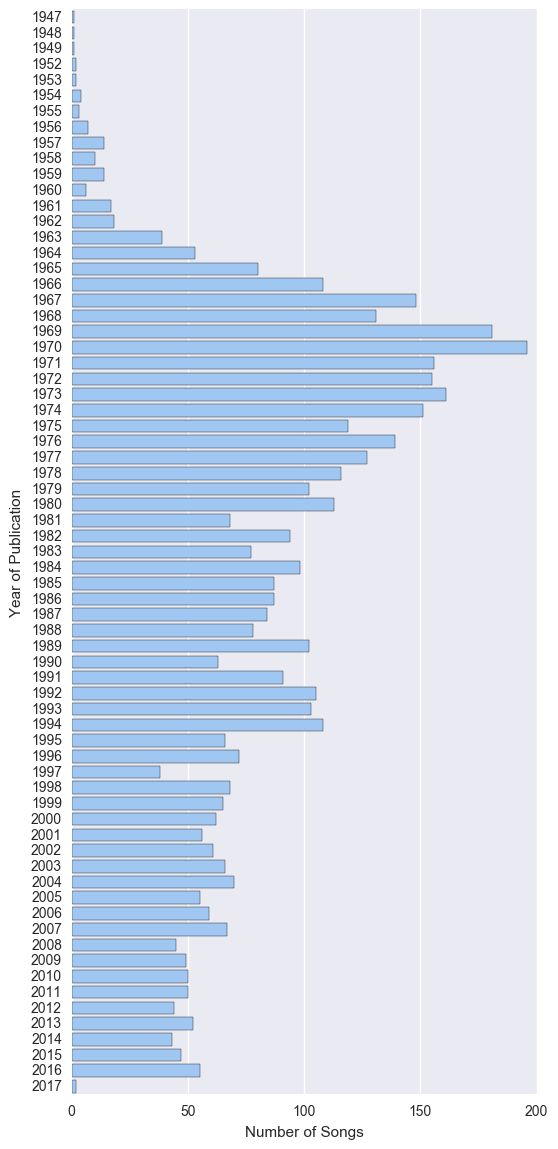

In [17]:

c = playlist['Year'].value_counts()
year_counts = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Year', 'Count'))
f, ax = plt.subplots(figsize=(6, 14))
sns.set_color_codes('pastel')
sns.barplot(y='Year', x='Count',
            data=year_counts[year_counts['Year'] > 1910],
            orient='h', color='b')
ax.set(xlabel="Number of Songs", ylabel="Year of Publication")


The data for years is based on an imperfect match,
so it might not really be 100%.
But it passes enough o a sniff test that
it's worth bringing this chart back.

There's a strong bias for late 60s and early 70's.
But it's a pretty wide thick distribution.
This is an audience that keeps up with new music.

Oh, those entries for 2017.  They are legit, sort of.
_The Castle_ by the Flaming Lips will be on _Oczy Mlody_,
due out Jan 17.
And _Astral Plane_ by Valerie June wil be on _The Order of Time_,
due out Jan 27.
Since the methodology we've used is to os the publish date
of the oldest physical release that contained a track for
the same title and the same artist,
we end up treating early downloads as being "from the future."

## Availability

The code for this project is in [my git hub repo](https://github.com/asudell/a2z).
The notebook its self is [published on nbviewer](http://nbviewer.jupyter.org/github/asudell/a2z/blob/master/AtoZ.ipynb)

## License

This project is licensed under a
[Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).
You are free to use for commercial or non-commercial purposes,
so long as you attribute the source and also allow sharing.

## Related Efforts

Apparently I'm not the only one who thought to do something like this.
Checkout [Bruce Segal's work](https://public.tableau.com/profile/besegal#!/vizhome/BESegalWXPNAtoZPlayListPublished/XPNAtoZFindYourSongfromAtoZ)
as well as [Lena Bartel's work](https://public.tableau.com/profile/lena.bartell#!/vizhome/XPN_AtoZ/XPNA-ZPlaylistData).
They explore the same topics, plus a few more.
And both use Tableau, which is very nice looking.
